#### NYC Taxi Fare Prediction
Predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

#### File descriptions
- train.csv - Input features and target fare_amount values for the training set (about 55M rows).
- test.csv - Input features for the test set (about 10K rows). Your goal is to predict fare_amount for each row.
- sample_submission.csv - a sample submission file in the correct format (columns key and fare_amount). This file 'predicts' fare_amount to be 11.35 for all rows, which is the mean fare_amount from the training set.

#### Data fields

#### ID
- key - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.
#### Features
- pickup_datetime - timestamp value indicating when the taxi ride started.
- pickup_longitude - float for longitude coordinate of where the taxi ride started.
- pickup_latitude - float for latitude coordinate of where the taxi ride started.
- dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
- dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
- passenger_count - integer indicating the number of passengers in the taxi ride.
#### Target
- fare_amount - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt  

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.


In [ ]:
# imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
palette = sns.color_palette('Paired', 10)
#------------------------------------------------------------
# imports machine learning libaries
# Preprocessing
from sklearn.preprocessing import MinMaxScaler # for scaling
# Metrics
from sklearn.metrics import mean_squared_error  # To calculate MSE
# Models
from sklearn.linear_model import LinearRegression  # for Linear Regression
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regressor
from xgboost import XGBRegressor # XGBoost Regressor
import xgboost as xgb
# Model selection
from sklearn.model_selection import train_test_split # for spliting data into test and train
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score  # cross validation
from sklearn.model_selection import KFold
# Set random seed 
seed = 39

In [ ]:
TRAIN_PATH = '../input/train.csv'
TEST_PATH = '../input/test.csv'
SAMPLE_SUBMISSION_PATH = '../input/sample_submission.csv'

## 1. DATA LOADING
Original size of train dataset is about 55M.  Let us read 6M sized data set

_Considering the range of each features and data types of pandas dataframe, following data type conversion shall be applied while reading data from disk_


In [ ]:
# preparing for reading train, test and submission data
# our chunk size
TRAIN_DATASIZE = 6_000_000  #10% of size
CHUNK_SIZE = 1_000_000

# define datatypes of each columns while reading
train_dtype  = {
'key'             :      'object',
'fare_amount'     :     'float32',
'pickup_datetime' :      'str',
'pickup_longitude':     'float32',
'pickup_latitude' :     'float32',
'dropoff_longitude':    'float32',
'dropoff_latitude' :    'float32',
'passenger_count'  :      'int16'
}

test_dtype  = {
'key'             :      'object',
'pickup_datetime' :      'str',
'pickup_longitude':     'float32',
'pickup_latitude' :     'float32',
'dropoff_longitude':    'float32',
'dropoff_latitude' :    'float32',
'passenger_count'  :      'int16'
}

submission_dype  = {
'key'             :      'object',
'fare_amount'     :     'float32'
}

In [ ]:
# Helper function to read data via read_csv interface
def read_csv(path, dtype, chunksize = None, totalsize = None):
    """
    Inputs:
    ------
    path -> str, path to dataset
    dtype -> dict of column
    chunksize -> int, Return TextFileReader object for iteration
    totalsize -> int, total size of dataset, must be specified when chunksize is not null
    Output:
    -------
    pandas DataFrame 
    
    """
    if chunksize != None:
        # Create lists to hold dataframe chunks
        data_lst = []
        # Get reader object
        reader = pd.read_csv( TRAIN_PATH, dtype = dtype, chunksize = chunksize )

        index = 1
        for df_data in reader:
            data_lst.append(df_data)
            del df_data
            print('Rows read so far {0} M'.format(index * chunksize / (1e6)))
            
            # terminate if number of rows read is greater than totalsize
            if index * chunksize >= totalsize:
                break
            index = index + 1
        # creat combined dataframe and drop list of dataframe
        df_data = pd.concat(data_lst)
        del data_lst
    
    elif totalsize == None:  # read entire file
        
        df_data = pd.read_csv(path, dtype = dtype)
        
    else:  # read partial file as specified by totalsize
        
        df_data = pd.read_csv(path, dtype = dtype, nrows= totalsize )
    
    print('data ' + path + ' is read')
    return df_data

In [ ]:
%%time
train       =    read_csv(path = TRAIN_PATH, dtype = train_dtype, chunksize = CHUNK_SIZE, totalsize = TRAIN_DATASIZE)
test        =    read_csv(path = TEST_PATH, dtype = test_dtype)
submission  =    read_csv(path = SAMPLE_SUBMISSION_PATH, dtype = submission_dype)

In [ ]:
train.shape, test.shape, submission.shape

In [ ]:
list(train.columns)

_Drop the feature 'Key'' as this is unique and we don't need for processing. We have already read sample submission file where we get key information. (as long as test dataset is not shuffled :-) :-)_

In [ ]:
for df in [train, test]:
    df.drop('key', axis = 1, inplace = True)
train.shape, test.shape,

In [ ]:
# Check the train datasize in bytes
train.info(memory_usage = True)

## 2. DATA EXPLORATION

### 2.1 Descriptive analysis

In [ ]:
summary = train.describe().fillna('')
summary

In [ ]:
summary = test.describe().fillna('')
summary

### 2.2 Data cleaning
- Distribution of train and test dataset is different (mean and std) may be due to outliers in train dataset
- Also few % data is missing in train dataset (may be dropped)

#### 2.2.1 passenger_count
- Max value of passenger count is found to be abnormal. Taxi can carry maximum of 6 passengers. Drop rows where number of passengers are more than 6

In [ ]:
# percentage passengers travelled between 1 and 6
str( 100 * len( train[train.passenger_count.between(1, 6)] ) / len(train) ) + ' %'

In [ ]:
train = train[train.passenger_count.between(1,6)]

#### 2.2.2 fare_amount
- Observed negative fare amount and also max fare_amount as 75%th percentile is about 12.5
- Minimum [fare](https://www.investopedia.com/articles/personal-finance/021015/uber-versus-yellow-cabs-new-york-city.asp) in NYC is doller 2.5

In [ ]:
# Lets take 99.73 % confidence interval (3 sigma)
percentile_99_73 = train.fare_amount.quantile(0.9973)
percentile_99_73

In [ ]:
# percentage passengers paid fare_amount between 2.5 and 60
str( 100 * len( train[train.fare_amount.between(2.5, 60)] ) / len(train) ) + ' %'

In [ ]:
train = train[train.fare_amount.between(2.5, 60)]

#### 2.2.3 Geographical coordinates
- Found strange values in training dataset
- Latitude is ranging from 0 to 90 towards southern and northern hemisphere from equator
- longitude is ranging from 0 to 180 towards eastern and western hemisphere from prime meridian
- NYC is located towards western hemisphere (0 to -180)
- Also used [geocoding bounding box](https://www.mapdevelopers.com/geocode_bounding_box.php) to locate NYC coordinates
- North Latitude: 40.917577 South Latitude: 40.477399 East Longitude: -73.700272 West Longitude: -74.259090
- North Latitude: 40.9 South Latitude: 40.5 East Longitude: -73 West Longitude: -74.3 # Adjusted manually

In [ ]:
# percentage passengers were picked up location (latitude)
str( 100 * len( train[train.pickup_latitude.between(40.5, 40.9)] ) / len(train) ) + ' %'

In [ ]:
# percentage passengers were dropped up location (latitude)
str( 100 * len( train[train.dropoff_latitude.between(40.5, 40.9)] ) / len(train) ) + ' %'

In [ ]:
# percentage passengers were picked up location (longitude)
str( 100 * len( train[train.pickup_longitude.between(-74.3, -73)] ) / len(train) ) + ' %'

In [ ]:
# percentage passengers were dropped up location (longitude)
str( 100 * len( train[train.dropoff_longitude.between(-74.3, -73)] ) / len(train) ) + ' %'

In [ ]:
train = train[train.pickup_latitude.between(40.5, 40.9)]
train = train[train.dropoff_latitude.between(40.5, 40.9)]
train = train[train.pickup_longitude.between(-74.3, -73)]
train = train[train.dropoff_longitude.between(-74.3, -73)]

#### 2.2.4 pickup_datetime
- No inference is made from this feature as in current form. Year, month, day and hour information needs to extracted to get some insight

###  2.3 Missing info

In [ ]:
train.isnull().mean().sum(), test.isnull().mean().sum() 

## 3 DATA EXPLORATION AND FEATURE ENGINEERING

### 3.1 Feature correlation with labels 
_Though assumptions about pearson correlation is not validated, it would provide rough idea about corrleation_

In [ ]:
corr = train.corr()['fare_amount']
corr.sort_values(ascending = False)

### 3.2 Fare amount distribution

In [ ]:
ax = train.fare_amount.plot(kind = 'hist', color = 'tab:orange', grid = True)
ax.set_xlabel('Fare amount', color = 'tab:blue')
ax.set_ylabel('Frequency',color = 'tab:blue')
plt.suptitle('Fare amount distribution', color = 'tab:blue')

In [ ]:
train['fare_amount_bin'] = \
    pd.cut(train.fare_amount, bins = 10, precision = 1, right = False, include_lowest = True)

train['fare_amount_bin'] = pd.cut(train['fare_amount'], bins = list(range(0, 60, 5))).astype(str)
train.loc[train['fare_amount_bin'] == 'nan', 'fare_amount_bin'] = '[55+]'
train.loc[train['fare_amount_bin'] == '(5, 10]', 'fare_amount_bin'] = '(05, 10]'

ax = train.fare_amount_bin.value_counts().sort_index().plot(kind = 'bar', color = 'tab:orange', grid = True)
ax.set_xlabel('Fare amount (group)', color = 'tab:blue')
plt.suptitle('Fare amount distribution', color = 'tab:blue')


<font color = 'Blue' size = 4> Right skewed. Many passengers paid between 2.5 and 20 dollers </font>

### 3.3 Creating absolute distance between latitute and longitude

In [ ]:
train['latitude_abs'] = (train.pickup_latitude - train.dropoff_latitude).abs()
train['longitude_abs'] = (train.pickup_longitude - train.dropoff_longitude).abs()

test['latitude_abs'] = (test.pickup_latitude - test.dropoff_latitude).abs()
test['longitude_abs'] = (test.pickup_longitude - test.dropoff_longitude).abs()

In [ ]:
train_subsample = train.sample(n = 2000, random_state = seed) # subsample to avoid more computation time
train_subsample['fare_bin'] = pd.cut(train_subsample.fare_amount, bins = 6)
g = sns.FacetGrid(train_subsample, hue = 'fare_amount_bin', height = 6, aspect = 1.25 )
g = g.map(plt.scatter, "latitude_abs", "longitude_abs").add_legend()
del train_subsample

<font color = 'Blue' size = 4> As expected higher fare amount is charged inside the city. </font>
<br>
Distance feature to be created from coordinates with reasonable accuracy, an important factor for fare calculation

### 3.3 Creating a Feature 'Distance'
Thanks to [wikipedia](https://en.wikipedia.org/wiki/Geographical_distance)
for the calculation the distance between geographical coordinates

Calculating the distance between geographical coordinates is based on some level of abstraction; it does not provide an exact distance, which is unattainable if one attempted to account for every irregularity in the surface of the earth.[1] Common abstractions for the surface between two geographic points are:

- Flat surface;
- Spherical surface;
- Ellipsoidal surface.

#### Flat-surface formulae
A planar approximation for the surface of the earth may be useful over small distances. The accuracy of distance calculations using this approximation become increasingly inaccurate as:

The separation between the points becomes greater;
- A point becomes closer to a geographic pole.
- Spherical Earth projected to a plane
This formula takes into account the variation in distance between meridians with latitude:

This approximation is very fast and produces fairly accurate result for small distances Also, when ordering locations by distance, such as in a database query, it is much faster to order by squared distance, eliminating the need for computing the square root.

In [ ]:
PI = 3.14159265359
deg_to_rad = PI/180.0
earth_rad = 6371.009 #Miles

def distance_bn_coordinates(lat1, log1, lat2, log2):
    delta_lat = (lat2 - lat1)*deg_to_rad
    delta_log = (log2 - log1)*deg_to_rad
    mean_lat =  deg_to_rad * ( lat2 + lat1 ) /2.0
    dist = earth_rad * np.sqrt(
            np.power(delta_lat,2.0) + 
            np.power(np.cos(mean_lat)*delta_log,2.0)
                       )
    return dist

In [ ]:
def calculate_euclidean_distance(lat1, log1, lat2, log2):
    lat_sq = np.power((lat2-lat1), 2.0)
    log_sq = np.power((log2-log1), 2.0)
    
    return np.sqrt(lat_sq+log_sq)

In [ ]:
from math import radians, cos, sin, asin, sqrt
def haversine_distance(lat1, lon1, lat2, lon2):

      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

In [ ]:
use_feature = True
if use_feature == True:
    # calculate the distance between pickup and dropoff geographical coordinates
    train['distance'] = distance_bn_coordinates(train.pickup_latitude ,train.pickup_longitude,
                             train.dropoff_latitude  ,train.dropoff_longitude)

    test['distance'] = distance_bn_coordinates(test.pickup_latitude ,test.pickup_longitude,
                             test.dropoff_latitude  ,test.dropoff_longitude)

In [ ]:
use_feature = False
if use_feature == True:
    # calculate the euclidean distance  between pickup and dropoff geographical coordinates
    train['euclidean_distance'] = calculate_euclidean_distance(train.pickup_latitude ,train.pickup_longitude,
                             train.dropoff_latitude  ,train.dropoff_longitude)

    test['euclidean_distance'] = calculate_euclidean_distance(test.pickup_latitude ,test.pickup_longitude,
                             test.dropoff_latitude  ,test.dropoff_longitude)

In [ ]:
## Correlation with fare amount
train[['distance', 'fare_amount']].corr()

<font color = 'Blue' size = 4> Strong postive correlation is observed between distance and fare amount as expected </font>
<br>
Let analyse the distance feature further

In [ ]:
summary = pd.concat([train.distance.describe(), test.distance.describe()], axis=1)
summary.T

<font color = 'Red' size = 4> Zero distance is observed, which was not expected, lets explore further </font>
<br>

### 3.4 Creating Time features based on pickoff_datetime

In [ ]:
def get_timefeatures(df):
    pickup_datetime = df.pickup_datetime.copy()
    pickup_datetime = pickup_datetime.str.slice(0, 16)
    pickup_datetime = pd.to_datetime(pickup_datetime, utc=True, format='%Y-%m-%d %H:%M')
    df['year'] = pickup_datetime.dt.year.astype('uint16')
    df['month'] = pickup_datetime.dt.month.astype('uint8')
    df['day'] = pickup_datetime.dt.day.astype('uint8')
    df['dayofweek'] = pickup_datetime.dt.dayofweek.astype('uint8')
    df['hour'] = pickup_datetime.dt.hour.astype('uint8')
    df['minute'] = pickup_datetime.dt.minute.astype('uint8')
   
    del pickup_datetime
    return df

In [ ]:
train = get_timefeatures(train)
test = get_timefeatures(test)

In [ ]:
basic_features = ['distance', 'longitude_abs', 'latitude_abs','passenger_count']
original_features = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude']
time_features = ['year', 'month', 'day', 'dayofweek', 'hour', 'minute']

In [ ]:
# drop pickup_datetime
train.drop('pickup_datetime', axis= 1, inplace = True)
test.drop('pickup_datetime', axis=1, inplace = True)

In [ ]:
train.shape, test.shape

### 3.5 Spliting Train and Val dataset

In [ ]:
test_size = 100_000 / len(train)
X_train, X_val, y_train, y_val = train_test_split (train, train.fare_amount, \
                                test_size = test_size, random_state = seed, stratify = train.fare_amount_bin)

X_train.shape, X_val.shape, y_train.shape, y_val.shape, test.shape

In [ ]:
del train

### 3.6 Explore and create additional features based on pickup time
- Trend of fare_amount (mean) on year, month and day and time

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize =(12,8), sharey = True)
fare_amount_mean_year = X_train.groupby('year')['fare_amount'].mean()
fare_amount_mean_month = X_train.groupby('month')['fare_amount'].mean()
fare_amount_mean_day = X_train.groupby('day')['fare_amount'].mean()
fare_amount_mean_dayofweek = X_train.groupby('dayofweek')['fare_amount'].mean()
fare_amount_mean_hour = X_train.groupby('hour')['fare_amount'].mean()
fare_amount_mean_minute = X_train.groupby('minute')['fare_amount'].mean()

fare_amount_mean_year.plot(kind = 'line', color = 'tab:blue', ax = axes[0,0])
fare_amount_mean_month.plot(kind = 'line', color = 'tab:orange', ax = axes[0,1])
fare_amount_mean_day.plot(kind = 'line', color = 'tab:green', ax = axes[0,2])
fare_amount_mean_dayofweek.plot(kind = 'line', color = 'tab:red', ax = axes[1,0])
fare_amount_mean_hour.plot(kind = 'line', color = 'tab:purple', ax = axes[1,1])
fare_amount_mean_minute.plot(kind = 'line', color = 'tab:pink', ax = axes[1,2])

axes[0,0].set_ylabel('Mean fare amount', color = 'tab:brown')
axes[1,0].set_ylabel('Mean fare amount',color = 'tab:brown')

### 3.7 Explore and create additional features based on number of passengers


In [ ]:
fare_amount_mean_passenger_count = X_train.groupby('passenger_count')['fare_amount'].mean()
ax = fare_amount_mean_passenger_count.plot(kind = 'line', color = 'tab:orange')
ax.set_ylabel('Mean fare amount', color = 'tab:blue')
ax.set_xlabel('Passenger count', color = 'tab:blue')

### 3.8 Correlation of features with fare amount


In [ ]:
correlation = X_train.corr()['fare_amount'].sort_values(ascending = False)
correlation = correlation[correlation.index != 'fare_amount']
ax = correlation.plot(kind = 'bar', color = 'tab:orange')
ax.set_ylabel('Correlation score wrt fare amount', color = 'tab:blue')
ax.set_xlabel('Features', color = 'tab:blue')

## 4. BASELINE PERFORMANCE

In [ ]:
### HELPER FUNCTIONS
# Funcion to calculate root mean squared error
def calculate_rmse (y_true, y_pred):
    root_mean_squared_error = sqrt(mean_squared_error(y_true, y_pred))
    return root_mean_squared_error

# function to help to submit test data results
def submit_fare_amount(y_pred, filename):
    """
    fare_amount: is pandas series object of size equal to test data size or single floating point value
    """
    if isinstance(y_pred, pd.Series):
        submission.update(y_pred)
    elif isinstance(y_pred, float):
        submission.fare_amount = y_pred
    else:
        raise ValueError('y_pred is neither Pandas Series nor float')
    
    submission.to_csv(filename, index=False)
    print('Successfully written in ' + filename)
    display(submission.fare_amount.head(5).ravel())
    
#--------------------------------------------------------------------------------------------------------------------------

# Lets create Pandas Dataframe to capture the metrics to verify improvements based on our model
tuples = [('RMSE', 'Train'), ('RMSE', 'CV'),('RMSE', 'Val'), ('RMSE', 'Submission')]
columns = pd.MultiIndex.from_tuples(tuples)
Metrics = pd.DataFrame(columns = columns)
Metrics.index.name = 'Model'
Metrics

### 4.1 Navi baseline performance

In [ ]:
# imputing mean_fare_amount of train dataset into Val and test dataset
y_pred = pd.Series(X_train.fare_amount.mean(), index = X_train.fare_amount.index)
train_rmse = calculate_rmse(X_train.fare_amount, y_pred)

y_pred = pd.Series(X_train.fare_amount.mean(), index = X_val.fare_amount.index)
val_rmse = calculate_rmse(X_val.fare_amount, y_pred)

y_pred = pd.Series(X_train.fare_amount.mean(), index = test.index)
y_pred.name = X_train.fare_amount.name
submit_fare_amount(y_pred, 'Navi_Baseline.csv')

Metrics.loc['Navi Baseline'] = [train_rmse, '', val_rmse, '']
Metrics

### 4.2 Linear Regression (Simple machine learning model)


In [ ]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = seed)

<div class="alert alert-danger">
strategy:  _X_train shall be subsampled further to select, tune and do the feature selection to reduce the computation time_
</div>



In [ ]:
# drop target variable from train and val set
X_train = X_train.drop(['fare_amount','fare_amount_bin'], axis=1)
X_val = X_val.drop(['fare_amount','fare_amount_bin'], axis=1)
X_train.shape, X_val.shape, test.shape

In [ ]:
def run_model(model, model_name, features, target, usecv = False):
   
    print('fitting the training data...')
    #fit model, zero index in train dataset
    model.fit(features[0], target[0])
    print('model is trained')
    #predict 
    print('predicting train and test data')
    pred =[]
    for f in features:
        pred.append(model.predict(f))
    
    #evaluate
    if usecv == True:
        print('using cross validation')
        cvres = cross_val_score(model, features[0],target[0], \
                                scoring = 'neg_mean_squared_error', cv = kfold, n_jobs = -1)


        cv_mean = np.mean(np.sqrt(np.abs(cvres)))
        cv_std = np.std(np.sqrt(np.abs(cvres)))
    else:
        print('No cross validation')
        cv_mean =0
        cv_std =0
    
    #test
    rmse =[]
    for t, p in zip(target, pred):
        rmse.append(calculate_rmse(t, p))
    
    print('submitting..')
    #submit
    submission_pred = pd.Series(pred[2], index = submission.index)
    submission_pred.name = submission.fare_amount.name
    print(submission_pred.head())
    submit_fare_amount(submission_pred, model_name + '.csv')
    
    print('updating metrics..')
    #update Metrics
    Metrics.loc[model_name] = [rmse[0], str(np.round(cv_mean,2))+' +/- '+ str(np.round(cv_std,2)),rmse[1], '']
    display(Metrics)
    
    return pred

In [ ]:
X = pd.concat([X_train, y_train], axis = 1)
X_sample = X.sample(frac = 0.1 , random_state = seed) #10% of dataset
y_train_sample = X_sample.fare_amount
X_train_sample = X_sample.drop('fare_amount', axis=1)
del X
X_train_sample.shape, y_train_sample.shape

In [ ]:
%%time
# with only basic features
execute_model = False
if execute_model:
    # Linear Regression
    linReg = LinearRegression(n_jobs = -1)  #use all CPUs
    model_name = 'Linear_Regression'
    features = [X_train_sample[basic_features],X_val[basic_features],test[basic_features]]                                 
    target = [y_train_sample, y_val]
    pred = run_model(linReg, model_name, features, target)

In [ ]:
%%time
# with only basic features + time features
execute_model = False
if execute_model:
    # Linear Regression
    linReg = LinearRegression(n_jobs = -1)  #use all CPUs
    model_name = 'Linear_Regression_with_time_features'
    features = [X_train_sample[basic_features+time_features],X_val[basic_features+time_features],test[basic_features+time_features]]                                 
    target = [y_train_sample, y_val]
    pred = run_model(linReg, model_name, features, target)

In [ ]:
%%time
# with only basic features + time features + original features
execute_model = False
if execute_model:
    # Linear Regression
    linReg = LinearRegression(n_jobs = -1)  #use all CPUs
    model_name = 'Linear_Regression_with_time_and_original_features'
    features = [X_train_sample[basic_features+time_features+original_features],\
                X_val[basic_features+time_features+original_features],test[basic_features+time_features+original_features]]                                 
    target = [y_train_sample, y_val]
    pred = run_model(linReg, model_name, features, target)

<font color = 'Green' size = 4> Linear Regression performance outperforms (~50%) Navi baseline and hence the problem is fit for machine learning </font>
Better performance when all features are included

## 5 MODEL BUILDING
- Lets consider some non linear models like Random forest and Xgboost regressor

### 5.1 RandomForest Regressor

In [ ]:
%%time
execute_model = False
if execute_model:
    # start with simple parameters with 10 estimators, depth of 5
    randReg = RandomForestRegressor(n_jobs=-1, random_state=seed, max_depth = 10, n_estimators = 20, verbose = 0)
    model_name = 'Simple_RandomForest_Regressor_all_features'
    features = [X_train_sample,X_val,test]                                 
    target = [y_train_sample, y_val]
    pred = run_model(randReg, model_name, features, target)

### 5.2 XGBoost Regressor

In [ ]:
%%time
execute_model = False
if execute_model:
    xgbReg = XGBRegressor(n_jobs=-1, random_state=seed, max_depth = 20, \
                          n_estimators = 50, silent = True)
    model_name = 'XGBoost_Regressor'
    features = [X_train_sample,X_val,test]                                 
    target = [y_train_sample, y_val]
    pred = run_model(xgbReg, model_name, features, target)

In [ ]:
# Features of importance
execute_model = False
if execute_model:
    feat_impot = pd.Series(xgbReg.feature_importances_, index = X_train_sample.columns).sort_values(ascending = False)
    ax = feat_impot.plot(kind = 'bar', color = 'tab:orange', title = 'feature importances XGBoost')
    ax.set_ylabel('Feature importance', color = 'tab:blue')
    ax.set_xlabel('Features', color = 'tab:blue')

### 5.3 Results of the Models
<br>
<font color = 'Green' size = 5> XG booster outperforms other models and the same will be tuned to improve further </font>

### Results so far
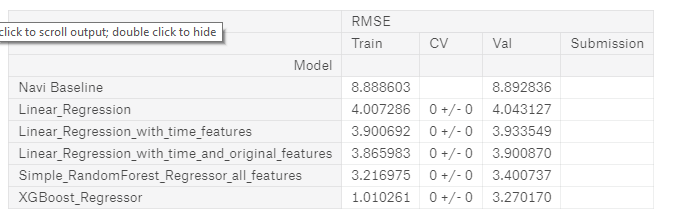

## 6. MODEL TUNING

In [ ]:
def xbg_GridSearchCV(model, params, param_grid, dtrain, num_boost_round = 200, \
                 nfold = 3, metrics = 'rmse', early_stopping_rounds = 1000, seed = seed):
    
    cvres = {}
    #params_grid only one list is supported
    for param_name, grid in param_grid.items():
        for value in grid:
            params[param_name] = value
            res = model.cv(params, dtrain, num_boost_round = num_boost_round, \
                    nfold = nfold, metrics = metrics, early_stopping_rounds = early_stopping_rounds, seed = seed)
            
            cvres[param_name + '_' + str(value)] = res.iloc[-1,:]
            display(pd.DataFrame(cvres).T)
            print('\n')

            
    cvres = pd.DataFrame(cvres).T
    idx = cvres['test-rmse-mean'].idxmin()
    cvres.loc[idx, 'best'] = 'yes'
    cvres.fillna('', inplace=True)
    return cvres

In [ ]:
# data interface (DMatrix) for Xgboost
data = X_train_sample
label = y_train_sample
dtrain = xgb.DMatrix(data = data, label = label, feature_names = data.columns)
dtest = xgb.DMatrix(data = X_val, label = y_val, feature_names = X_val.columns)

In [ ]:
# Specify parameters
params = {}
# Learning Task Parameters
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['seed'] = seed

#General Parameters
params['silent'] = 1
params['nthread'] = -1

#General Parameters
params['eta'] = 0.2
params['gamma'] = 0 #0 --> done
params['max_depth'] = 5 #6 --> done
params['min_child_weight'] = 1  #1  --> Done
params['max_delta_step'] = 0
params['subsample'] = 1 #1 --> done
params['colsample_bytree'] = 1 #1 --> done
params['colsample_bylevel'] = 1
params['lambda'] = 1 #10 done
params['alpha'] = 0 #0 done
watchlist  = [(dtrain, 'train'),(dtest, 'eval')]

In [ ]:
# Testing for 2 rounds to check decreasing trend and whether training is started from base margin or continutining
num_boost_round = 2
bst = xgb.train(params, dtrain, num_boost_round, watchlist, early_stopping_rounds = 50)

In [ ]:
%%time
# Train for required rounds and print end results

# eval metric is decreasing, run for more rounds
tuned_model = True
if tuned_model == False:
    num_boost_round = 115
    #params['max_depth'] = 10
    bst = xgb.train(params, dtrain, num_boost_round,watchlist, early_stopping_rounds = 50)
    print ( bst.eval_set(watchlist) )

In [ ]:
# store the output_margin to enable to continue training
ptrain = bst.predict(dtrain, output_margin = True)
ptest = bst.predict(dtest, output_margin = True)
dtrain.set_base_margin(ptrain)
dtest.set_base_margin(ptest)

In [ ]:
%%time
tuned_model = True
if tuned_model == False:
    # parameter tuning (single parameter at a time) with default cv =3
    # Model tuning parameter by parameter
    param_grid = {'eta': [0.05, 0.1, 0.2, 0.3]}
    num_boost_round = 115
    cvres = xbg_GridSearchCV(xgb, params, param_grid, dtrain, num_boost_round)

## Features importances
distance                           0.212
dropoff_longitude                  0.192
pickup_longitude                   0.140
dropoff_latitude                   0.139
pickup_latitude                    0.094
year                               0.058
hour                               0.053
dayofweek                          0.029
month                              0.020
fare_amount_mean_month             0.017
fare_amount_mean_hour              0.014
minute                             0.011
day                                0.009
passenger_count                    0.006
fare_amount_mean_dayofweek         0.003
fare_amount_mean_passenger_count   0.003
fare_amount_mean_year              0.000

In [ ]:
%%time
# RUN TO our model
tuned_model = False
if tuned_model == False:
    xgbReg = XGBRegressor(**params, n_jobs=-1, n_estimators = 50)
    model_name = 'XGBoost_Regressor_with_100K'
    features = [X_train_sample,X_val,test]                                 
    target = [y_train_sample, y_val]
    pred = run_model(xgbReg, model_name, features, target)

In [ ]:
%%time
# run with full set 1M
tuned_model = False
if tuned_model == False:
    xgbReg = XGBRegressor(**params, n_jobs=-1, n_estimators =50)
    model_name = 'XGBoost_Regressor_with_6M'
    features = [X_train,X_val,test]                                 
    target = [y_train, y_val]
    pred = run_model(xgbReg, model_name, features, target, usecv = False)

In [ ]:
feat_impot = pd.Series(xgbReg.feature_importances_, index = X_train.columns).sort_values(ascending = False)
ax = feat_impot.plot(kind = 'bar', color = 'tab:orange', title = 'feature importances XGBoost')
ax.set_ylabel('Feature importance', color = 'tab:blue')
ax.set_xlabel('Features', color = 'tab:blue')